### Visualization of Object Counts within City Boundary Using Choropleth Map. 
This script generates a choropleth map to visualize the distribution of object counts (e.g., cafes, restaurants, bars) within a city boundary. It first processes the geometry data to count the occurrences of each object type per hexagon. Then, it creates a choropleth layer on a Folium map, overlaying the city boundary and color-coding the hexagons based on the object counts. Finally, it displays the map with a layer control for easy toggling.

In [2]:
%reset -f

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import h3
import folium
import osmnx as ox
from shapely import wkt
from folium.plugins import HeatMap
from shapely.geometry import Polygon, MultiPolygon
from IPython.display import IFrame

In [4]:
# Visualizes a list of hexagons on a Folium map
def visualize_hexagons(hexagons, color="red", folium_map=None):

    # Initialize lists to store coordinates
    polylines = []
    lat = []
    long = []

    # Iterate over hexagons
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0], polyline))
        long.extend(map(lambda v:v[1], polyline))
        polylines.append(polyline)

    # Create a new Folium map
    m = folium.Map(location=[sum(lat)/len(lat), sum(long)/len(long)], zoom_start=15, tiles='cartodbpositron')

    # Add polylines (hexagon outlines) to the map
    for poly in polylines:
        new_polyline=folium.PolyLine(locations=poly, weight=8, color=color)
        m.add_child(new_polyline)

    # Save the map to an HTML file and return the iframe
    m.save('map.html')
    return IFrame('map.html', width=500, height=500)

# Example usage
lat, long = 43.59783, 3.90203
resolution = 9
h3_address = h3.geo_to_h3(lat, long, resolution)                                                                                                 
visualize_hexagons([h3_address])

In [5]:
# Extracts latitude and longitude coordinates from a GeoDataFrame of geometries.
def get_coordinate(geoms):
    
    # Extract longitude for Point geometries, centroid longitude for Polygon geometries
    long = geoms.apply(lambda x: x.x if x.geom_type == 'Point' else x.centroid.x)
    
    # Extract latitude for Point geometries, centroid latitude for Polygon geometries
    lat = geoms.apply(lambda x: x.y if x.geom_type == 'Point' else x.centroid.y)
    
    return lat, long


# Visualizes the boundary of a city on a Folium map.
def visualize_boundary(geoms):

    # Get latitude and longitude coordinates from the boundary geometries
    lats, longs = get_coordinate(geoms)
    
    # Calculate the average latitude and longitude for map centering
    avg_lat = sum(lats) / len(lats)
    avg_long = sum(longs) / len(longs)
    
    # Create a Folium map centered on the average coordinates
    m = folium.Map(location=[avg_lat, avg_long], zoom_start=12.2, tiles='cartodb positron')

    # Convert boundary geometries to GeoJSON and add them as an overlay to the map
    overlay = gpd.GeoSeries(geoms).to_json()
    folium.GeoJson(overlay, name='boundary').add_to(m)
    
    return m


# Example usage with my case
city_name = 'Montpellier'
boundary = ox.geocode_to_gdf(city_name)

visualize_boundary(boundary['geometry'])

In [6]:
# Creates hexagons within a boundary polygon and visualizes them on a Folium map.
def create_hexagons(geo_json):
    
    # Extracting the coordinates of the boundary polygon
    polyline = geo_json['coordinates'][0]
    
    # Closing the polygon by appending its first vertex to the end
    polyline.append(polyline[0])
    
    # Extracting latitudes and longitudes from the polyline
    latitudes = [p[0] for p in polyline]
    longitudes = [p[1] for p in polyline]
    
    # Creating a Folium map centered at the average of the polygon's coordinates
    m = folium.Map(location=[sum(latitudes)/len(latitudes), sum(longitudes)/len(longitudes)], zoom_start=12.2, tiles='cartodb positron')
    
    # Adding the boundary polyline to the map
    boundary_polyline = folium.PolyLine(locations=polyline, weight=8, color="#4d4c4c")
    m.add_child(boundary_polyline)

    # Generating hexagons within the polygon
    hexagons = list(h3.polyfill(geo_json, 9))
    polylines = []
    
    # Extracting boundary polylines for each hexagon
    for hexagon in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hexagon], geo_json=False)
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        polylines.append(polyline)
    
    # Adding hexagon boundaries to the map
    for poly in polylines:
        new_polyline = folium.PolyLine(locations=poly, weight=2, color='#ff6600')
        m.add_child(new_polyline)
        
    # Converting boundary polylines to polygons
    poly_x = []
    for j in range(len(polylines)):
        a = np.column_stack((np.array(polylines[j])[:, 1], np.array(polylines[j])[:, 0])).tolist()
        poly_x.append([(a[i][0], a[i][1]) for i in range(len(a))])
        
    polygons_hex = pd.Series(poly_x).apply(lambda x: Polygon(x))
        
    return m, polygons_hex, polylines

# Converting the city boundary geometry to GeoJSON format
geo_json = json.loads(gpd.GeoSeries(boundary['geometry']).to_json())
geo_json = geo_json['features'][0]['geometry']
geo_json = {'type': 'Polygon', 'coordinates': [np.column_stack((np.array(geo_json['coordinates'][0])[:, 1],
                                                               np.array(geo_json['coordinates'][0])[:, 0])).tolist()]}

# Generating hexagons and visualizing them
m, polygons, polylines = create_hexagons(geo_json)
m

In [7]:
# Counting and printing amenities within the city boundary

cafes = ox.features_from_polygon(boundary.geometry[0], tags={'amenity': 'cafe'})
fast_food = ox.features_from_polygon(boundary.geometry[0], tags={'amenity': 'fast_food'})
restaurants = ox.features_from_polygon(boundary.geometry[0], tags={'amenity': 'restaurant'})
bars = ox.features_from_polygon(boundary.geometry[0], tags={'amenity': 'bar'})
wine_bars = ox.features_from_polygon(boundary.geometry[0], tags={'amenity': 'bar', 'cuisine': 'wine_bar'})

print("Number of cafes in the city:", len(cafes))
print("Number of fast food establishments in the city:", len(fast_food))
print("Number of restaurants in the city:", len(restaurants))
print("Number of bars in the city:", len(bars))

Number of cafes in the city: 135
Number of fast food establishments in the city: 278
Number of restaurants in the city: 567
Number of bars in the city: 125


In [8]:
# Extracting geographical features from OpenStreetMap
def features_from_osm(tag, city):
    
    # Extract features from OpenStreetMap for the specified tag and city
    gdf = ox.features_from_place(city, tag).reset_index()
    
    # Add city, object, and type columns to the GeoDataFrame
    gdf['city'] = np.full(len(gdf), city.split(',')[0])
    gdf['object'] = np.full(len(gdf), list(tag.keys())[0])
    gdf['type'] = np.full(len(gdf), tag[list(tag.keys())[0]])
    
    # Select relevant columns
    gdf = gdf[['city', 'object', 'type', 'geometry']]

    # Group by city, object, and type, and count the number of geometries
    gdf.groupby(['city','object','type'], as_index = False).agg({'geometry':'count'})
    
    # Get coordinates for each geometry
    lat, long = get_coordinate(gdf['geometry'])
    gdf['lat'] = lat
    gdf['long'] = long
    return gdf


# Define tag with amenities to search for
tag = {'amenity': ['cafe', 'fast_food', 'restaurant', 'bar']}

# List to store GeoDataFrames for each tag
gdf_objects_list = []

# Iterate over each tag and its values
for key, values in tag.items():
    for value in values:
        gdf = features_from_osm({key: value}, city_name)
        gdf_objects_list.append(gdf)

# Concatenate all GeoDataFrames in the list
gdf_objects = pd.concat(gdf_objects_list, ignore_index=True)

# Print the information of objects in the city
print("Number of objects in the city:", len(gdf_objects))
print(gdf_objects['type'].unique())

Number of objects in the city: 1105
['cafe' 'fast_food' 'restaurant' 'bar']


In [9]:
# Function to join hexagons with attribute data
def join_hexagons_objects(hexagons, data):

    # Convert attribute data to a GeoDataFrame with Point geometries
    first_part = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.long, data.lat))

    # Create a DataFrame for hexagons with their geometries
    second_part = pd.DataFrame(hexagons, columns = ['geometry'])
    second_part['polylines'] = hexagons
    
    # Convert geometry column to string for merging
    second_part['geometry'] = second_part['geometry'].astype(str)
    
    # Create a DataFrame with unique geometries and IDs
    geometry_ui = pd.DataFrame(second_part['geometry'].drop_duplicates())
    geometry_ui['id'] = np.arange(len(geometry_ui)).astype(str)
    
    # Merge the unique geometries with IDs into the second_part DataFrame
    second_part = second_part.merge(geometry_ui, on = 'geometry')
    
    # Convert the geometry column back to Shapely geometries
    second_part['geometry'] = second_part['geometry'].apply(wkt.loads)
    second_part = gpd.GeoDataFrame(second_part, geometry='geometry')
    second_part.crs = "EPSG:4326"

    # Perform a spatial join between hexagons and attribute data
    new_data = gpd.sjoin(second_part, first_part, how='left', predicate='intersects')
    
    # Drop rows with NaN values
    new_data = new_data.dropna()
    return new_data


gdf_objects_hex = join_hexagons_objects(polygons, gdf_objects)
print(gdf_objects_hex.head(2))
print(len(gdf_objects_hex))

                                            geometry  \
1  POLYGON ((3.87680 43.58857, 3.87455 43.58914, ...   
3  POLYGON ((3.88767 43.61272, 3.88993 43.61215, ...   

                                           polylines id  index_right  \
1  POLYGON ((3.876802526772535 43.5885672273276, ...  1       1087.0   
3  POLYGON ((3.887674272087758 43.61272481971489,...  3       1066.0   

          city   object type        lat      long  
1  Montpellier  amenity  bar  43.586030  3.874808  
3  Montpellier  amenity  bar  43.614183  3.889397  
1099


In [10]:
# Check for the presence of null or missing values in the 'lat' and 'long' columns
num_null_lat = gdf_objects_hex['lat'].isna().any()
num_null_long = gdf_objects_hex['long'].isnull().any()

print("Number of null or missing values in the 'lat' column:", num_null_lat)
print("Number of null or missing values in the 'long' column:", num_null_long)

Number of null or missing values in the 'lat' column: False
Number of null or missing values in the 'long' column: False


In [15]:
# Define a function to create a choropleth layer on a Folium map
def choropleth_layer(boundary, data, json, columns, legend_name):

    # Compute the average latitude and longitude of the data
    lat, long = get_coordinate(data['geometry'])
    avg_lat = sum(lat) / len(lat)
    avg_long = sum(long) / len(long)

    # Create a Folium map centered at the average latitude and longitude
    m = folium.Map(location=[avg_lat, avg_long], zoom_start=13, tiles='cartodbpositron')

    # Add the boundary polyline to the map
    polyline = boundary['coordinates'][0]
    polyline.append(polyline[0])
    boundary_polyline = folium.PolyLine(locations=polyline, weight=2, color="#4d4c4c")
    m.add_child(boundary_polyline)

    # Add a choropleth layer to the map
    folium.Choropleth(
        geo_data=json,
        name="choropleth",
        data=data,
        columns=columns,
        key_on="feature.id",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name,
        nan_fill_color = 'red',
        bins = [1, 2, 5, 10, 20, 30, 50, 118],
    ).add_to(m)

    # Add a layer control to the map
    folium.LayerControl().add_to(m)
    return m

# Define a function to process geometry data
def process_geometry_data(gdf_obj_hex):
    
    # Convert geometry and id columns to string type
    # gdf_obj_hex['geometry'] = gdf_obj_hex['geometry'].astype(str)
    gdf_obj_hex['id'] = gdf_obj_hex['id'].astype(str)
    
    # Group by geometry and id and count occurrences of latitude
    counts_per_type = gdf_obj_hex.groupby(['geometry','id'], as_index = False).agg({'lat':'count'}).rename(columns = {'lat':'counts'})
    
    # Convert geometry column back to Shapely geometry objects
    counts_per_type['geometry'] = counts_per_type['geometry'].apply(wkt.loads)

    # Convert id column to string type
    counts_per_type['id'] = counts_per_type['id'].astype(str)
    
    return counts_per_type

# Define a function to convert geometry data to JSON format
def convert_geometry_to_json(counts_per_type_obj):
    data_json = gpd.GeoSeries(counts_per_type_obj.set_index('id')["geometry"]).to_json()
    return data_json

# Process geometry data
counts_per_type = process_geometry_data(gdf_objects_hex)

# Create and visualize choropleth layer
m = choropleth_layer(geo_json, counts_per_type, convert_geometry_to_json(counts_per_type), ["id","counts"], 'Object counts')
m


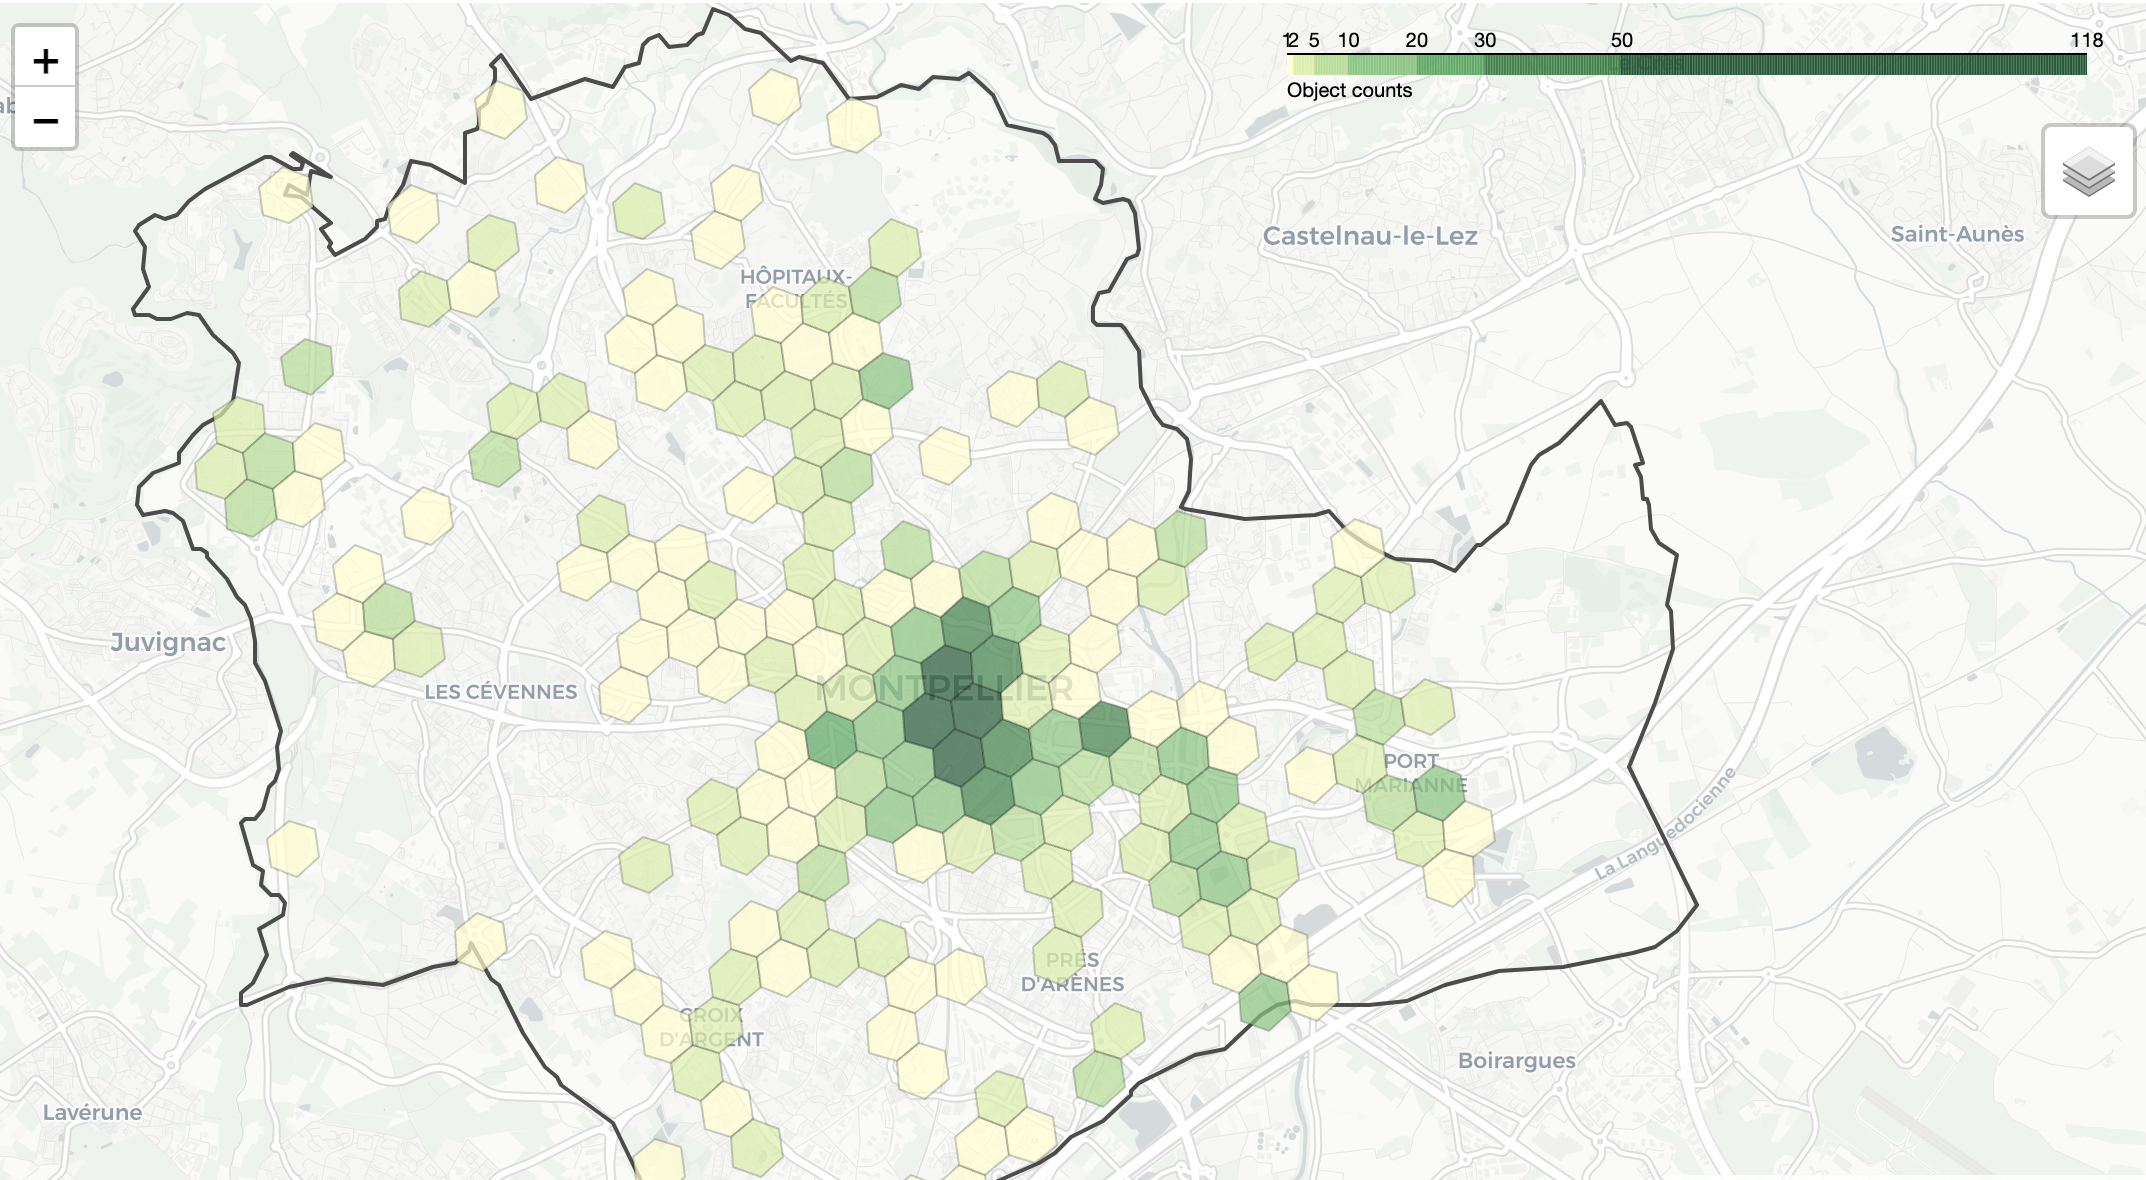

In [24]:
from IPython.display import Image

Image(filename="../resources/RestMontpellier.png")